In [1]:
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/eduardofc/data/main/amazon_sports.csv")
df['review_body'] = df['review_body'].str.replace("[^a-zA-ZñÑáéíóú .,]", "", regex=True)
df['review_body'] = df['review_body'].str.lower()
df.head()

,stars,review_body,review_title,product_category
0,1,nunca llego el pedido y el vendedor pasa de to...,No llego nunca,sports
1,1,"no sé como es, porque debería haber llegado ay...",Todavía no ha llegado,sports
2,1,"guantes cómodos, no lo niego, pero de mala cal...",Guantes de baja calidad,sports
3,1,hasta hoy no he visto el producto. el pedido h...,Muy Mala experiencia,sports
4,1,"no puedo valorarla porque, después de casi una...",Paquete perdido?,sports


In [8]:
df = df[df.stars != 3]
df['good_product'] = (df.stars > 3).astype(int)

df.groupby('good_product').size()

good_product
0    4989
1    5372
dtype: int64

## Modelo de keras con Embeddings

In [10]:
X = df.review_body.values
y = df.good_product

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000

tokenizer = Tokenizer(
    num_words=vocab_size,
    oov_token='<OOV>'
)

tokenizer.fit_on_texts(X)

In [16]:
# tokenizer.index_word
tokenized_X = tokenizer.texts_to_sequences(X)

In [17]:
max_length = 50

padded_X = pad_sequences(
    tokenized_X,
    maxlen=max_length,
    truncating='post'
)

In [18]:
padded_X

array([[   0,    0,    0, ...,   47,    7, 2976],
       [   0,    0,    0, ...,  319,    2,  181],
       [   0,    0,    0, ...,    9,  153, 4506],
       ...,
       [   0,    0,    0, ...,   82,   23, 2087],
       [   0,    0,  284, ...,    5, 5300, 3662],
       [   0,    0,    0, ...,  133,   12,  315]])

## Model

In [19]:
import tensorflow.keras as keras
from keras import Sequential
from keras.layers import *

keras.utils.set_random_seed(812)

In [22]:
embed_dim = 2

model = Sequential()
model.add(
    Embedding(
        input_dim=vocab_size,
        input_length=max_length,
        output_dim=embed_dim
    ),
)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics='accuracy'
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 2)             20000     
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20101 (78.52 KB)
Trainable params: 20101 (78.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.fit(
    padded_X,
    y,
    epochs=20
)

Epoch 1/20


324/324 [==============================] - 1s 2ms/step - loss: 0.6705 - accuracy: 0.5975
Epoch 2/20
324/324 [==============================] - 1s 2ms/step - loss: 0.5282 - accuracy: 0.7845
Epoch 3/20
324/324 [==============================] - 1s 2ms/step - loss: 0.3972 - accuracy: 0.8514
Epoch 4/20
324/324 [==============================] - 1s 2ms/step - loss: 0.3337 - accuracy: 0.8745
Epoch 5/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2938 - accuracy: 0.8906
Epoch 6/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2643 - accuracy: 0.9026
Epoch 7/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2397 - accuracy: 0.9149
Epoch 8/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2194 - accuracy: 0.9226
Epoch 9/20
324/324 [==============================] - 1s 2ms/step - loss: 0.2024 - accuracy: 0.9299
Epoch 10/20
324/324 [==============================] - 1s 2ms/step - loss: 0.1875 - accuracy: 0.93

# Embedding layer

In [28]:
embed_layer = model.layers[0]

In [31]:
embed_weights = embed_layer.get_weights()[0]
embed_weights.shape

(10000, 2)

In [33]:
for ww in ['bueno', 'malo', 'horrible']:
    ii = tokenizer.word_index[ww]
    print(f"{ww} -> {embed_weights[ii]}")

bueno -> [-0.2917331 -0.4774868]
malo -> [0.33241826 0.21074195]
horrible -> [0.8098156 0.7277537]


In [34]:
words = []
x_axis = []
y_axis = []
for k, v in tokenizer.index_word.items():
    x, y = embed_weights[k]
    words.append(v)
    x_axis.append(x)
    y_axis.append(y)
    if k == 1500:
        break

In [35]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource

output_notebook()

source = ColumnDataSource(data=dict(x=x_axis, y=y_axis, words=words))
p = figure(tools="", title="2-dim embeddings space")
p.circle('x', 'y', size=2, source=source)
hover = HoverTool()
hover.tooltips = [("Palabra", "@words"), ("(x,y)", "($x, $y)")]
p.add_tools(hover)   
show(p)

Loading BokehJS ...

# Similitud del coseno

In [36]:
import numpy as np

In [37]:
# (comedia, intriga, terror, thriller, aventuras, sci-fi) n=6

v_toy_story = np.array([3, 1, 0, 1, 5, 4])
v_mission_imp = np.array([2, 5, 0, 5, 4, 2])
v_jurassic_park = np.array([1, 2, 1, 3, 5, 3])
v_exorcista = np.array([0, 4, 5, 3, 1, 2])

In [40]:
np.dot(v_toy_story, v_mission_imp)
np.dot(v_toy_story, v_jurassic_park)
np.dot(v_toy_story, v_exorcista)

20

In [44]:
# v_toy_story / v_toy_story.sum()
np.linalg.norm(v_toy_story)

7.211102550927978

In [47]:
np.dot(v_toy_story, v_mission_imp) / (np.linalg.norm(v_toy_story)*np.linalg.norm(v_mission_imp))
np.dot(v_toy_story, v_jurassic_park) / (np.linalg.norm(v_toy_story)*np.linalg.norm(v_jurassic_park))
np.dot(v_toy_story, v_exorcista) / (np.linalg.norm(v_toy_story)*np.linalg.norm(v_exorcista))

0.3739787960033829

In [48]:
def sim_cosine(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

In [50]:
# sim_cosine(v_toy_story, v_exorcista)

In [51]:
for ww in ['bueno', 'malo', 'horrible', 'encantado', 'mucho']:
    ii = tokenizer.word_index[ww]
    print(f"{ww} -> {embed_weights[ii]}")

bueno -> [-0.2917331 -0.4774868]
malo -> [0.33241826 0.21074195]
horrible -> [0.8098156 0.7277537]
encantado -> [-1.1582541 -1.2736839]
mucho -> [-0.23533541  0.04118969]


In [57]:
v1 = np.array([0.8098156 , 0.7277537])
v2 = np.array([-0.23533541, 0.04118969])

sim_cosine(v1, v2)

-0.6174119128596358

# Word2Vec

In [60]:
reviews = list(df.review_body.values)

In [62]:
reviews[:2]

['nunca llego el pedido y el vendedor pasa de todo no contestan',
 'no sé como es, porque debería haber llegado ayer día  de marzo, y hoy  por la noche sigo esperando que llegue el frontal. y me habéis mandado el formulario de opinión. pues de momento mala no ha cumplido con la fecha de entrega.']

In [63]:
sentences = []
for rr in reviews:
    ss = rr.split('.')
    for s in ss:
        s = s.strip()
        if len(s)>1:
            s = s.lower()
            s = s.replace("  ", " ")
            sentences.append(s)

In [64]:
sentences[:4]

['nunca llego el pedido y el vendedor pasa de todo no contestan',
 'no sé como es, porque debería haber llegado ayer día de marzo, y hoy por la noche sigo esperando que llegue el frontal',
 'y me habéis mandado el formulario de opinión',
 'pues de momento mala no ha cumplido con la fecha de entrega']

In [66]:
word_sentences = [ss.split() for ss in sentences]
word_sentences[0]

['nunca',
 'llego',
 'el',
 'pedido',
 'y',
 'el',
 'vendedor',
 'pasa',
 'de',
 'todo',
 'no',
 'contestan']

## Model

In [69]:
from gensim.models import Word2Vec

model = Word2Vec(
    sentences=word_sentences,
    vector_size=20,
    window=3
)

In [70]:
model.wv['bueno']

array([ 0.06021033, -0.6937423 ,  1.735991  ,  1.2236289 , -0.04476627,
        0.29644138,  0.507031  ,  1.4811655 , -0.71065694,  1.0445416 ,
        0.563266  , -0.46983233,  0.095117  , -0.22160603,  1.1750294 ,
        0.36297038,  0.58702016,  0.6223241 , -0.7511016 , -0.83979124],
      dtype=float32)

In [71]:
model.wv.most_similar(positive=['bueno'])

[('bonito', 0.9673020243644714),
 ('cómodo', 0.9592317342758179),
 ('agarre,', 0.935708224773407),
 ('recomendable', 0.9322715997695923),
 ('ajustado', 0.927386999130249),
 ('bonita', 0.9258125424385071),
 ('deficiente', 0.9251633882522583),
 ('genial', 0.9203728437423706),
 ('diseño', 0.9197316765785217),
 ('económico', 0.9190383553504944)]

In [72]:
model.wv.most_similar(positive=['buenos'])

[('acabados', 0.9891819953918457),
 ('bonitos', 0.9768776893615723),
 ('resistentes', 0.9743404388427734),
 ('cómodos', 0.9738910794258118),
 ('bonitas', 0.9698919057846069),
 ('cómodas', 0.9676697850227356),
 ('cómodos,', 0.9662338495254517),
 ('comodos', 0.9624007344245911),
 ('comodas', 0.9619547128677368),
 ('parecen', 0.9618603587150574)]

In [73]:
model.wv.similarity('buenos', 'bonitas')

0.96989185

In [81]:
words1 = [w for w, _ in model.wv.most_similar(positive='bueno')]
words2 = [w for w, _ in model.wv.most_similar(positive='malo')]

words1 = words1[:4]
words2 = words2[:4]

In [82]:
print(words1)
print(words2)

['bonito', 'cómodo', 'agarre,', 'recomendable']
['justo', 'veo', 'esperaba,', 'barato']


In [83]:
from sklearn.decomposition import PCA

words = words1 + words2

X = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

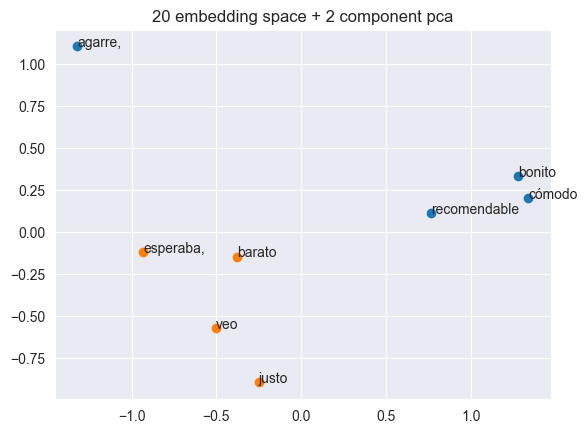

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

plt.scatter(result[:len(words1), 0], result[:len(words1), 1])
plt.scatter(result[len(words1):, 0], result[len(words1):, 1])
for i, w in enumerate(words):
    plt.annotate(w, xy=(result[i, 0], result[i, 1]))
plt.title("20 embedding space + 2 component pca")
plt.show()

# Sentence Transformer

In [86]:
df_st = df.sample(2000, replace=False, random_state=99)

In [87]:
reviews = list(df_st.review_body.values)

In [89]:
len(reviews)

2000

In [90]:
df_st.groupby('good_product').size()

good_product
0     977
1    1023
dtype: int64

## Model

In [92]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")

In [94]:
embeddings = model.encode(reviews, show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 63/63 [00:53<00:00,  1.17it/s]


In [97]:
len(embeddings)
len(embeddings[0])

768

## Visualization

In [98]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    n_iter=500
)

tsne_data = tsne.fit_transform(embeddings)

In [102]:
df_st[['x','y']] = tsne_data

In [104]:
df_st.head(1)

,stars,review_body,review_title,product_category,good_product,x,y
1187,1,lo quería porque trabajo en un club de fútbol ...,Que llegue el producto,sports,0,24.097536,-10.84129


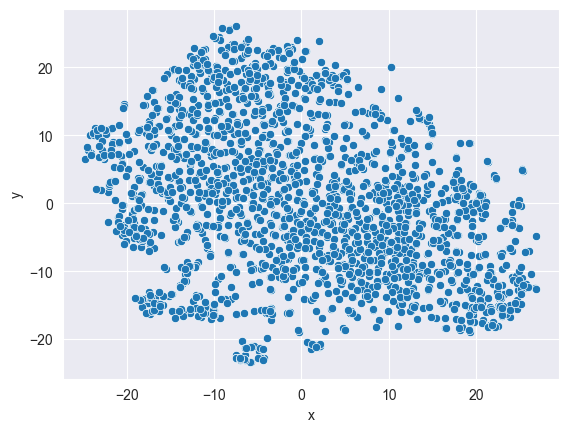

In [105]:
sns.scatterplot(data=df_st, x='x', y='y')
plt.show()

In [106]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.palettes import Viridis256
from bokeh.transform import linear_cmap

source = ColumnDataSource(data={
    "x": df_st['x'],
    "y": df_st['y'],
    "code": df_st['good_product'],
    "post":df_st['review_body']
})

mapper = linear_cmap(
    field_name='code', 
    palette=Viridis256, 
    low=0, high=2
)

p = figure(width=800, height=700, tools="pan,wheel_zoom,box_zoom,reset,hover,save")
p.circle('x', 'y', size=4, source=source, color=mapper, legend_group='code')

hover = p.select_one(HoverTool)
hover.tooltips = [
    ("Post", "@post"),
]

In [107]:
show(p)